# This notebook must be run with the ABC_Download conda environment within the ABC.sif singularity container

This code, and the following two notebooks, are largely inspired by the Allen Brain Cell Atlas's
MERFISH atlas. The code used was sourced and adapted from this github: https://github.com/ZhuangLab/whole_mouse_brain_MERFISH_atlas_scripts_2023/blob/main/scripts/integrate_MERFISH_with_scRNA-seq/integration_round1.ipynb

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import anndata
import scanpy as sc
sc.settings.n_jobs = 56
sc.settings.set_figure_params(dpi=180, dpi_save=300, frameon=False, figsize=(4, 4), fontsize=8, facecolor='white')

import ALLCools
from ALLCools.integration.seurat_class import SeuratIntegration

In [2]:
workspace_path = '/hpc/projects/group.quake/doug/references/ABC/whole/integration_workspace'
# Load the datasets
adata_seq = sc.read_h5ad(os.path.join(workspace_path, 'adata_seq_common_genes.h5ad'))

adata_merfish_raw = sc.read_h5ad(os.path.join(workspace_path, 'adata_merfish.h5ad'))
adata_merfish = adata_merfish_raw.copy()

/home/doug.henze/.conda/envs/ABC_Download/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
adata_merfish.X = adata_merfish.layers['counts']

sc.pp.normalize_total(adata_seq, target_sum=1000)
sc.pp.log1p(adata_seq)
sc.pp.scale(adata_seq)

sc.pp.normalize_total(adata_merfish, target_sum=1000)
sc.pp.log1p(adata_merfish)
sc.pp.scale(adata_merfish)

adata_merge = adata_seq.concatenate(adata_merfish,
                                    batch_categories=['seq', 'merfish'],
                                    batch_key='modality',
                                    index_unique=None)

n_pcs = 100
sc.tl.pca(adata_merge, svd_solver='arpack', n_comps=100)

adata_list = [adata_merge[adata_merge.obs['modality'] == 'seq'],
              adata_merge[adata_merge.obs['modality'] == 'merfish']
             ]

integrator = SeuratIntegration()
integrator.find_anchor(adata_list,
                       k_local=None,
                       key_local='X_pca',
                       k_anchor=5,
                       key_anchor='X',
                       dim_red='cca',
                       max_cc_cells=100000,
                       k_score=30,
                       k_filter=None, #why?
                       scale1=False,
                       scale2=False,
                       n_components=n_pcs,
                       n_features=200,
                       alignments=[[[0], [1]]])

/home/doug.henze/.conda/envs/ABC_Download/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/tmp/ipykernel_127306/977543652.py:11: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_merge = adata_seq.concatenate(adata_merfish,
/home/doug.henze/.conda/envs/ABC_Download/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/doug.henze/.conda/envs/ABC_Download/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/

Find anchors across datasets.
Run CCA
non zero dims 100
Find Anchors using k=30
Score Anchors
Identified 566601 anchors between datasets 0 and 1.


In [4]:
%%time
cell_type_col = 'integration_partition'

transfer_results = integrator.label_transfer(
    ref=[0],
    qry=[1],
    categorical_key=[cell_type_col],
    key_dist='X_pca',
    npc=n_pcs
)

integrator.save_transfer_results_to_adata(adata_merge, transfer_results)

Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Label transfer
CPU times: user 1h 12min 25s, sys: 11min 54s, total: 1h 24min 20s
Wall time: 7min 44s


In [5]:
adata_merfish_raw.obs[cell_type_col + '_transfer'] = transfer_results[cell_type_col].idxmax(axis=1
                                                                                           ).astype('category')
adata_merfish_raw.obs[cell_type_col + '_confidence'] = transfer_results[cell_type_col].max(axis=1)

n_transfered = len(np.unique(adata_merfish_raw.obs[cell_type_col + '_transfer']))
n_total = len(np.unique(adata_merge.obs[cell_type_col + '_transfer']))
print(f'Transfered {n_transfered}/{n_total} cell types.')

Transfered 54/54 cell types.


In [6]:
# Save the label transfer results for each class
partition_path = os.path.join(workspace_path, 'partitions')
partitions = np.unique(adata_merfish_raw.obs[cell_type_col + '_transfer'])

for pn in partitions:
    adata_subset = adata_merfish_raw[adata_merfish_raw.obs[cell_type_col + '_transfer'] == pn]
    adata_subset.write_h5ad(os.path.join(partition_path, pn.replace('/', '-').replace(' ', '_'), 
                                    'adata_merfish_integrated.h5ad'), compression='gzip')

In [7]:
%%time
# Correct the PCs using the integration anchors
corrected = integrator.integrate(key_correct='X_pca',
                                 row_normalize=True,
                                 n_components=n_pcs,
                                 k_weight=100,
                                 sd=1,
                                 alignments=[[[0], [1]]])

adata_merge.obsm['X_pca_integrate'] = np.concatenate(corrected)

Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data
CPU times: user 1h 12min 52s, sys: 12min 36s, total: 1h 25min 29s
Wall time: 7min 44s


In [8]:
sc.pp.neighbors(adata_merge, use_rep='X_pca_integrate')

/home/doug.henze/.conda/envs/ABC_Download/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


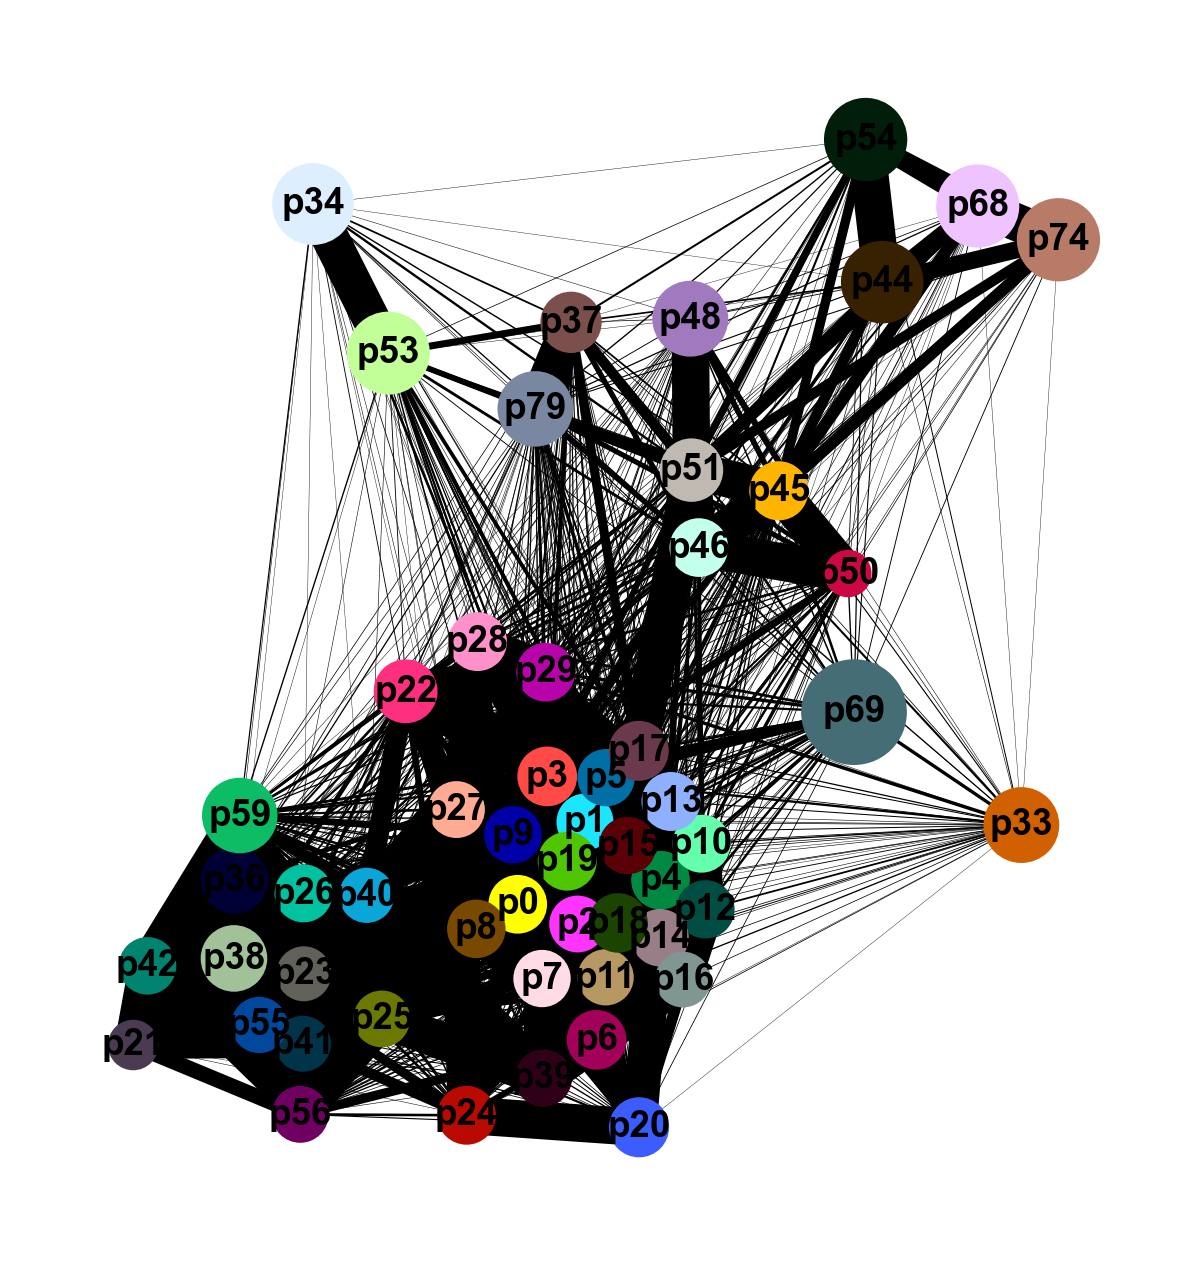

CPU times: user 3min 10s, sys: 5.23 s, total: 3min 15s
Wall time: 3min 15s


In [9]:
%%time
# Generate the PAGA plot for the initial arrangement of the UMAP
sc.tl.paga(adata_merge, groups=cell_type_col + '_transfer')
sc.pl.paga(adata_merge, save='_tmp.png')

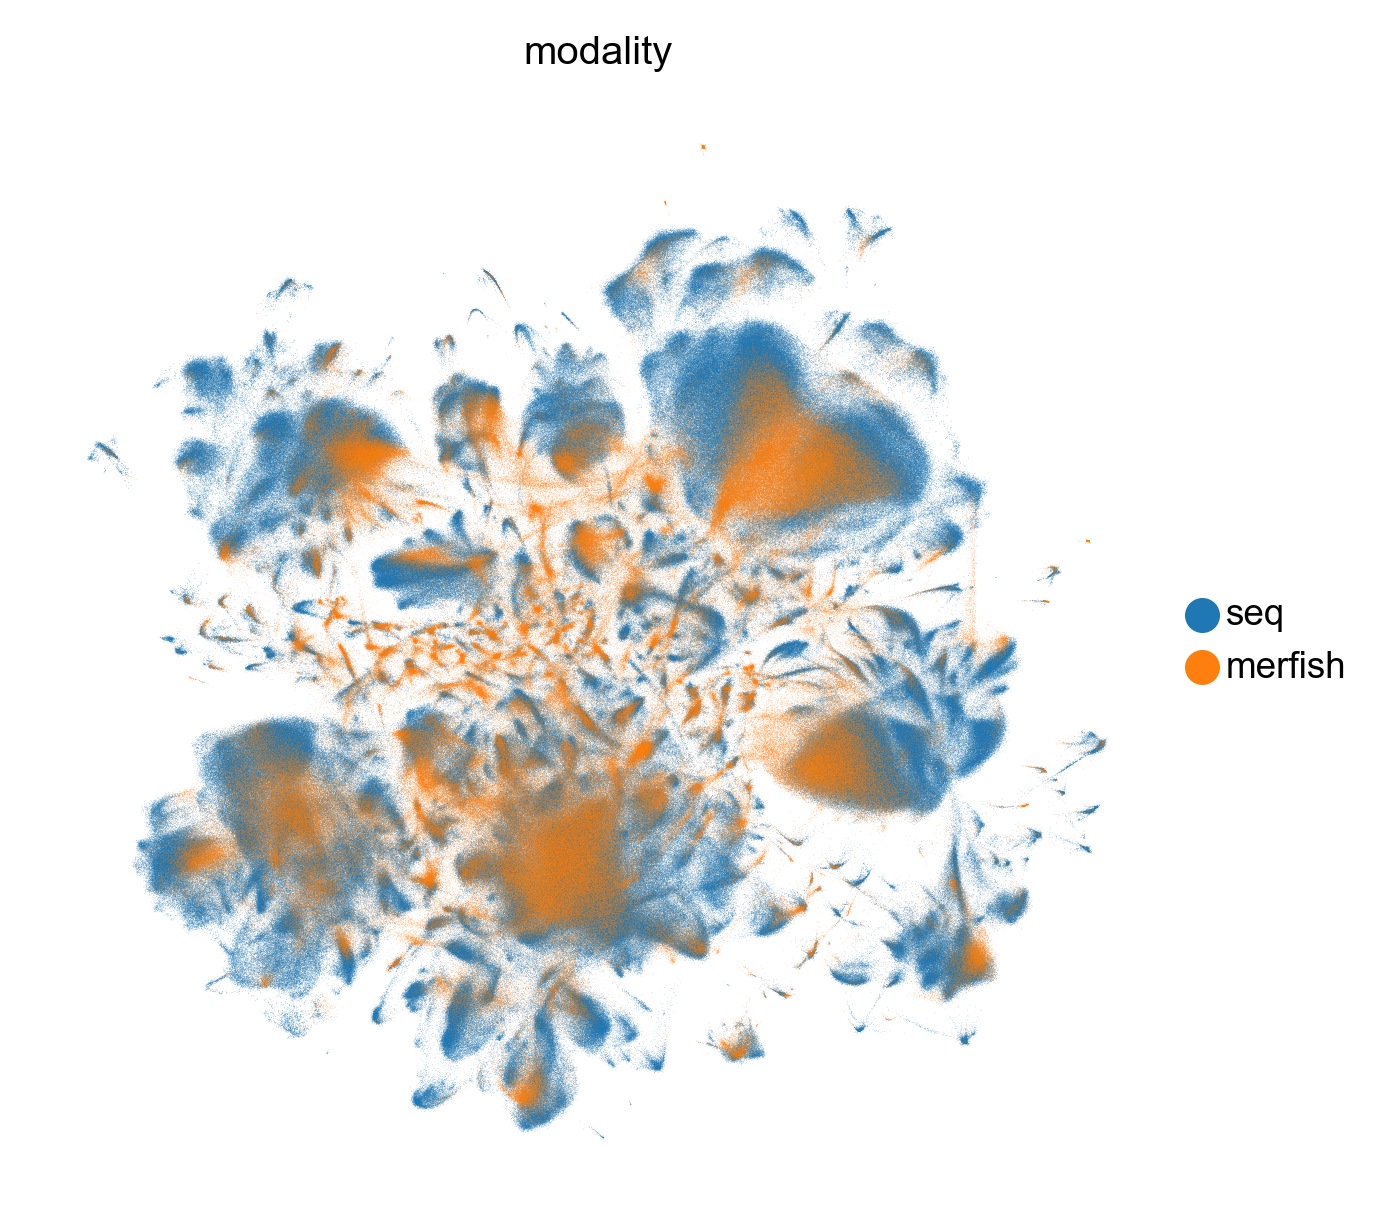

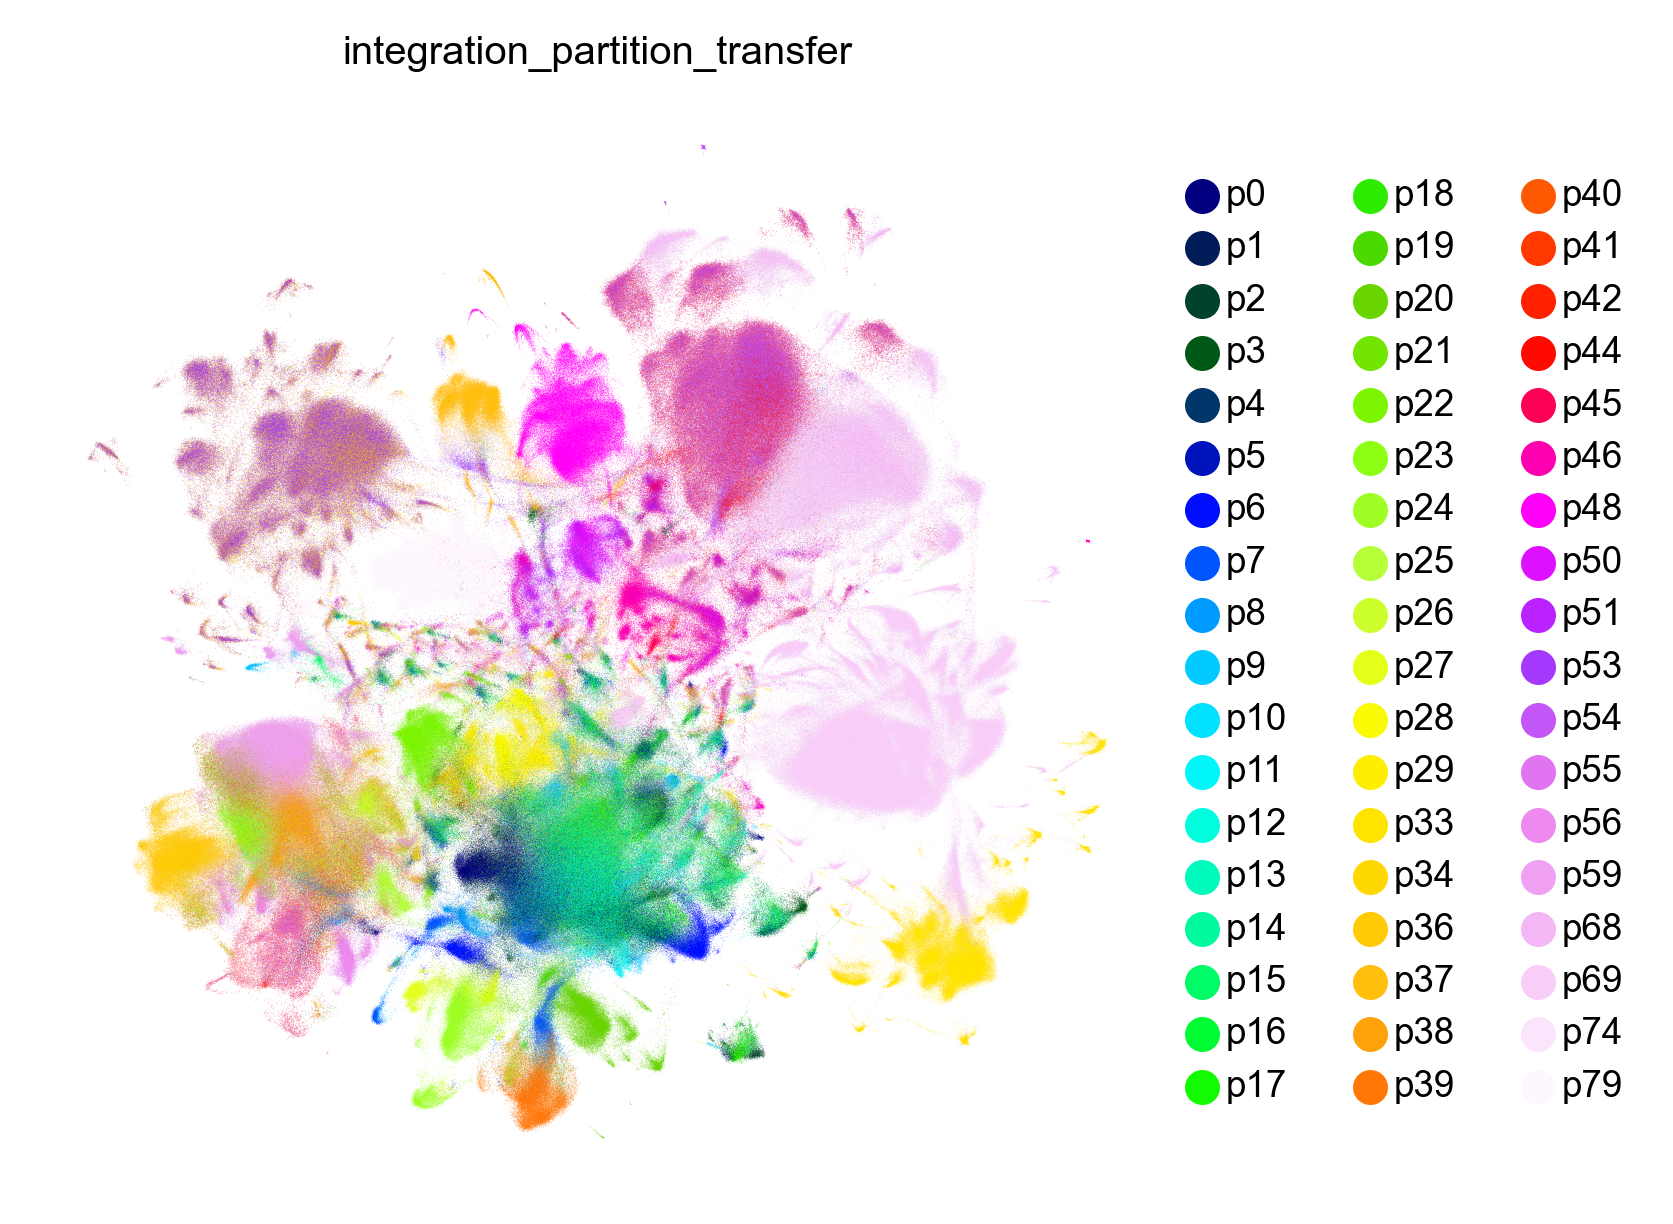

CPU times: user 45min 20s, sys: 4.39 s, total: 45min 25s
Wall time: 45min 21s


In [10]:
%%time
# Save the umap
sc.tl.umap(adata_merge, init_pos='paga', min_dist=0.5)
sc.pl.umap(adata_merge, color='modality', save='_tmp.png')
shutil.move('figures/umap_tmp.png', os.path.join(workspace_path, 'integration_umap_round1_modality.png'))
sc.pl.umap(adata_merge, color=cell_type_col + '_transfer', save='_tmp.png', palette='gist_ncar')

In [11]:
adata_merge.write_h5ad(os.path.join(workspace_path, 'adata_merged_round1.h5ad'), compression='gzip')

coembedding_umap_df = adata_merge.obs[[]].copy()
coembedding_umap_df['umap_x'] = adata_merge.obsm['X_umap'][:, 0]
coembedding_umap_df['umap_y'] = adata_merge.obsm['X_umap'][:, 1]
coembedding_umap_df.to_csv(os.path.join(workspace_path, 'coembedding_umap.csv'))